### Step 1. Examine the spectrum

In this tutorial, we will find the spectral trace (or spine) and then extract the spectra around them. The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

Let's start by importing the `extraction()` class from **easyspec**:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from easyspec.extraction import extraction
extraction = extraction()

easyspec-extraction version:  1.0.0


Now let's load our data. Notice that you can take the reddening for your target from this website: https://irsa.ipac.caltech.edu/applications/DUST/

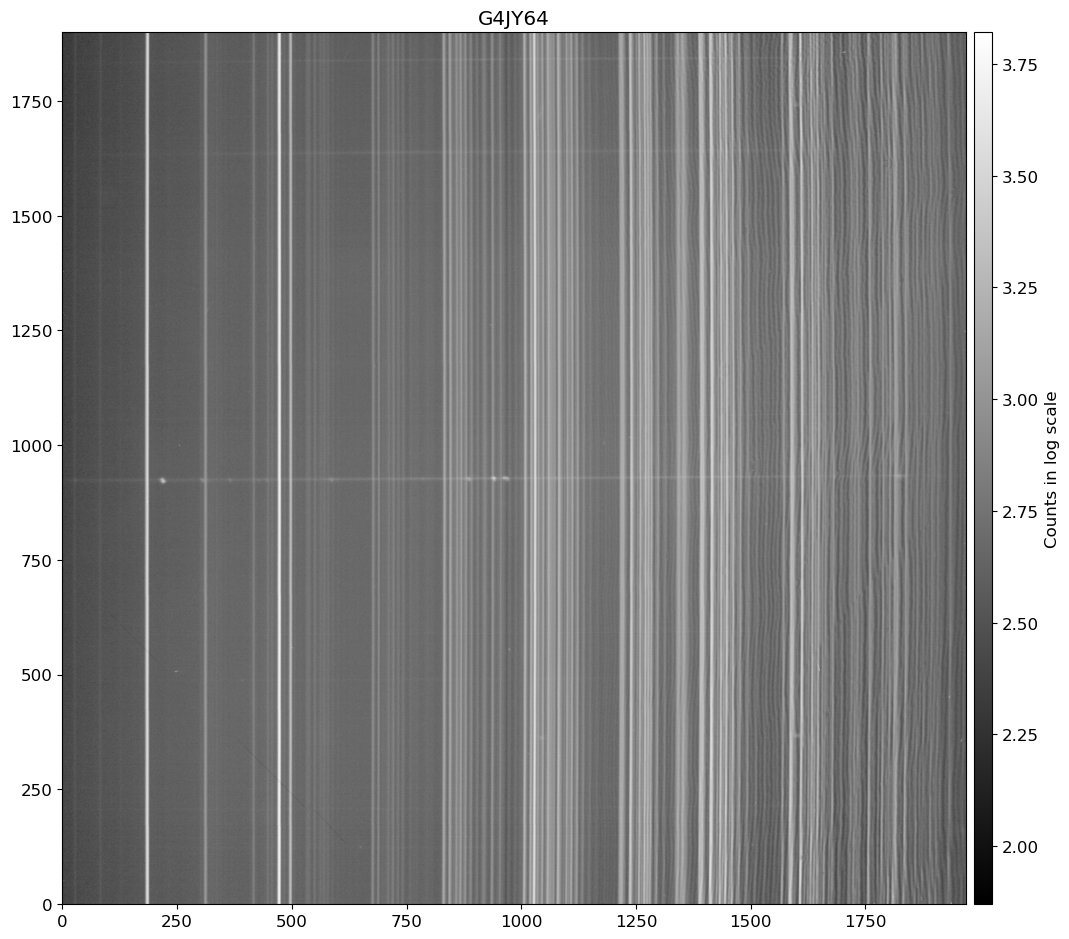

/home/raniere/Documentos/easyspec/TNG_2024_first_night/obs2024.09.06/easyspec/cleaning/cleaning.py:719: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), origin='lower', cmap='gray')


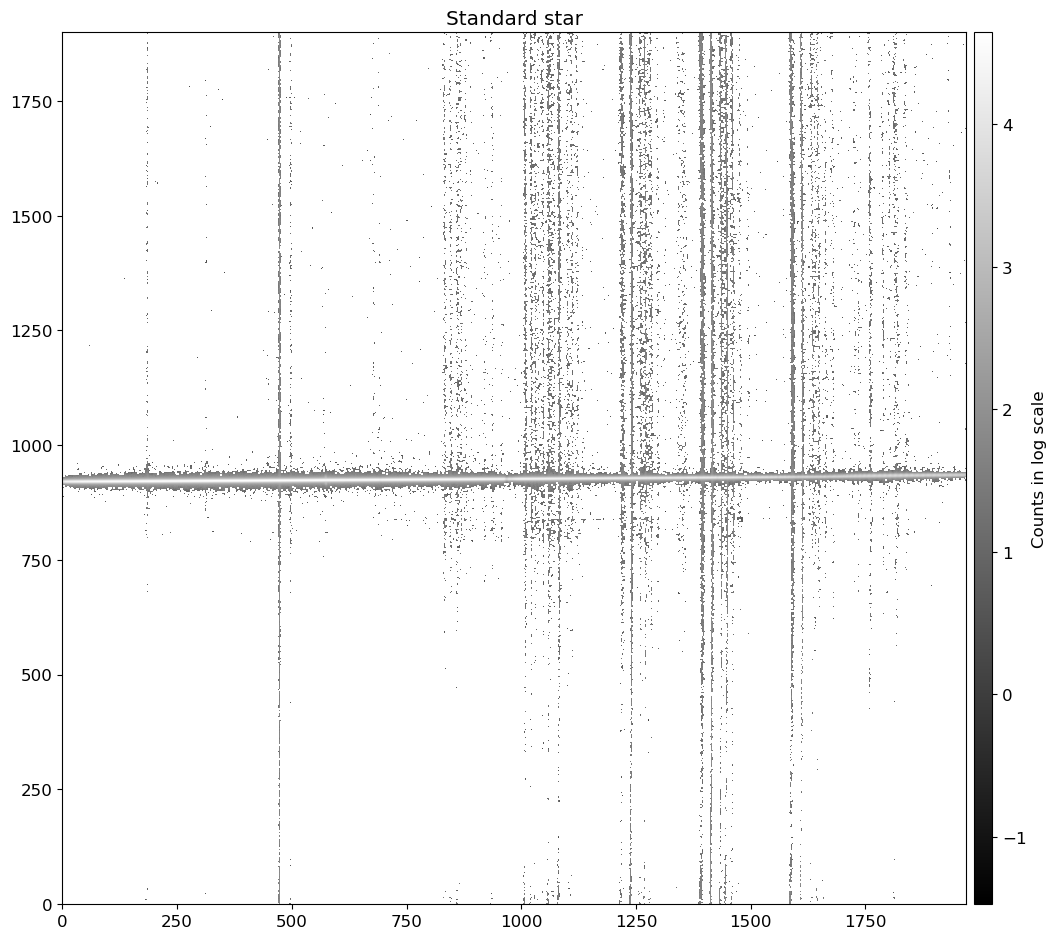

Returning both target and std star images...


In [29]:
output_directory = "./G4JY64_results"
target_name = "G4JY64"
std_star_file = "./master_standard_star.fits"
target_data_file = "./master_target_G4JY64.fits"
reddening = 0.0261

target_data, std_data = extraction.import_data(target_data_file,target_name, std_star_spec_file=std_star_file,plot=True)

The main goal of the trace is to obtain a model f(x) defining the vertical position of the light (the signal) along the detector.

### Step 2. Finding the spine

To obtain the trace, we first measure the maximum Y-value for each pixel column. We'll start with the trivial approach of using argmax:

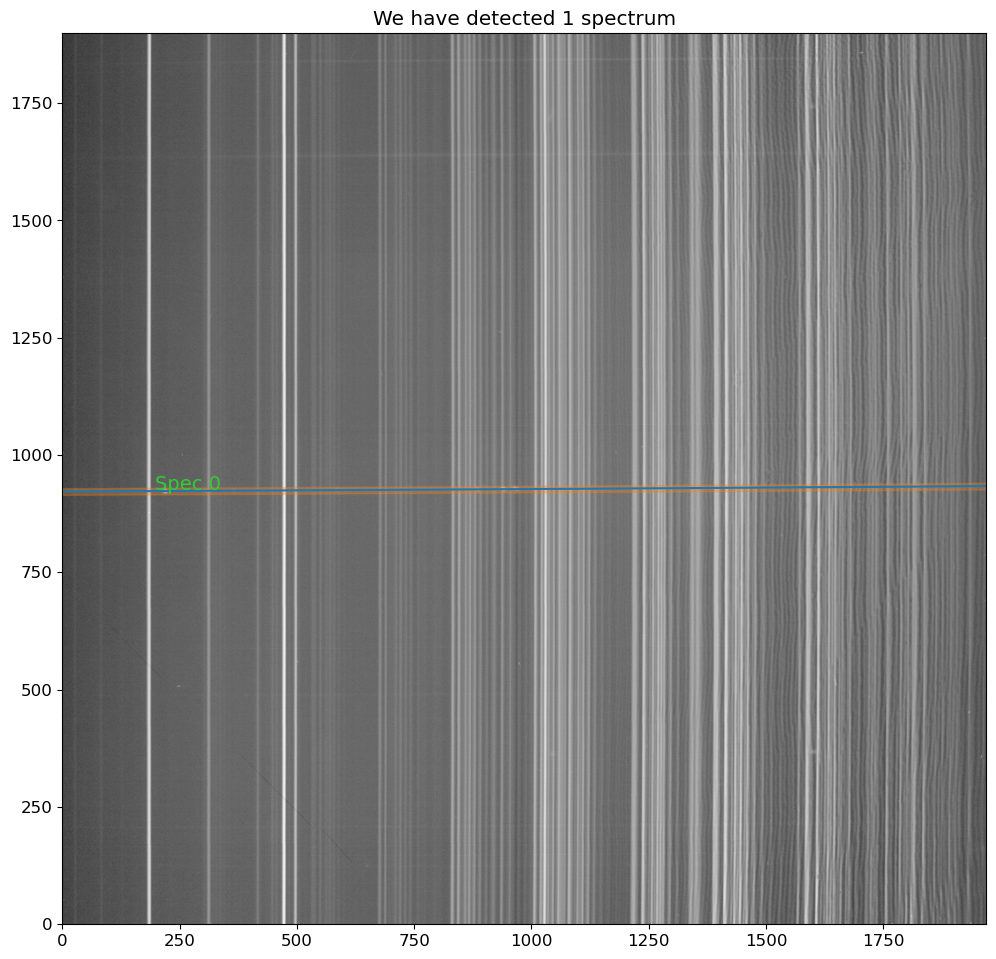

In [30]:
spine_list = extraction.tracing(target_data, method="argmax", peak_height=100, distance=100,poly_order=2, xlims=[100,2000], y_pixel_range=15, plot_residuals=False, main_plot=True)

The function `extraction.tracing()` fits a polynomial to recover the trace/spine of one or several spectra in an image. The input variable **method** can be set as "argmax" or "moments" if you want to extract only the strongest spectrum in the image, or "multi" if you want to extract more than one spectrum (give it a try!).

The variables **peak_height** and **distance** set the required average height of each spectrum and the minimum distance (>= 1) among them in pixels in the y-axis (default is 20 pixels). The smaller is the value of **peak_height**, the more spectra you will find in your image, at the cost of including low S/N sources.

**poly_order** is the degree of the polynomial used to extract the trace.

**xlims** is useful only if **method = "argmax"** or **method = moments**. It sets the limits in the x-axis delimiting the region where we will look for the spectra.

Now we can use the trace (or traces) saved in **spine_list** to extract the spectrum (or spectra).

### Step 3. Spectral extraction

In the function `extraction.extracting()` below we will extract the target and lamp spectra based on the trace computed in the previous step.

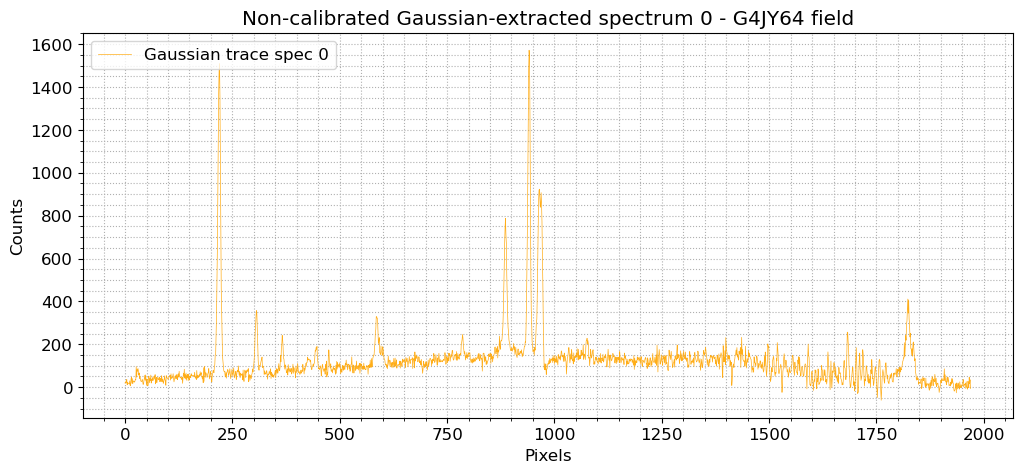

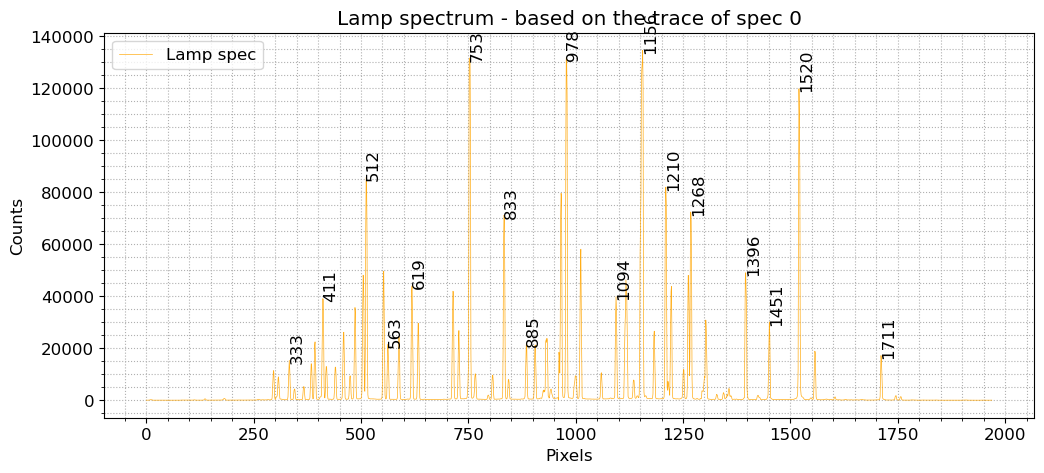

In [31]:
spec_extract_list, lamp_spec_list, lamp_peak_positions_list = extraction.extracting(target_data, spine_list, master_lamp_data="./master_lamp.fits", trace_half_width = 7, shift_y_pixels = 21, lamp_peak_height=10000, peak_distance = 50, diagnostic_plots = False, spec_plots = True)

Ok, these are the target and lamp non-calibrated spectra.

Remember to give the master_lamp fits file to the variable **master_lamp_data="./master_lamp.fits"**

**trace_half_width** = 7 is the The half-width of the trace in pixels. The spectra will be extracted within a region 2***trace_half_width** around their corresponding traces.

**shift_y_pixels** = 21: this is a very important parameter. It sets the vertical shift in the trace (in +- 21 pixels in this case) and repeat the extraction process to get the average sky spectrum around each trace.

**lamp_peak_height**=10000: The height of the lamp peaks (in counts and with respect to zero) to be detected.

**peak_distance** = 50: The minimum distance between peaks in pixels. Default is the length of the x-axis divided by 20.

## Step 4. Wavelength calibration

In this step you will have to compare the results find above with the calibration lamp of the telescope you used. In the previous function, easyspec found 17 peaks (given the input conditions) for the lamp spectrum and saved them in the variable **lamp_peak_positions_list**. The more lines you use in this case, the better is yoru calibration.

Since our data was observed with the TNG DOLORES spectrograph, we have to use the archival data for the DOLORES lamps. In case you need references for the lamp peaks, here are some databases you can use (as of 12 September, 2024):
 * TNG DOLORES spectrograph reference lamps can be found in table 1 here: https://www.tng.iac.es/instruments/lrs/
 * SOAR Goodman Spectrograph Reference Lamp Library: https://soardocs.readthedocs.io/projects/lamps/en/latest/
 * Observatorio do Pico dos Dias (OPD-LNA) spectrographs: https://www.gov.br/lna/pt-br/composicao-1/coast/obs/opd/instrumentacao/instrumentos-e-detectores

If you don't want to use all of these lines, you can play with the parameters of the previous function such that it will give you fewer lines, or even reset **lamp_peak_positions_list** by hand. For instance, let's say you want to use only 7 out of the 17 lines found above. You can simply reset:

In [32]:
lamp_peak_positions_list = [np.asarray([411, 553, 619, 833, 1156, 1520, 1711])]

And then create a list with the wavelengths corresponding to these pixels based on the archival lamp data:

In [33]:
corresponding_wavelengths = [6143.0626,6506.5281, 6678.2762, 7245.1666,8112.9012,9122.967,9657.7060]

Now we call the function `extraction.wavelength_calibration()` to calibrate the spectrum in wavelengths:

Spectrum 0:
Fit standard deviation = 1.2979403716196258 Angstrom


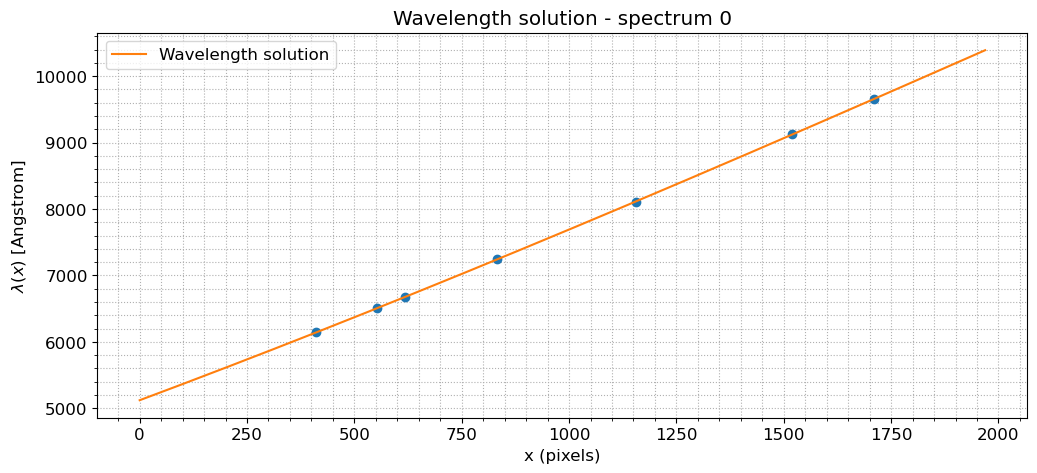

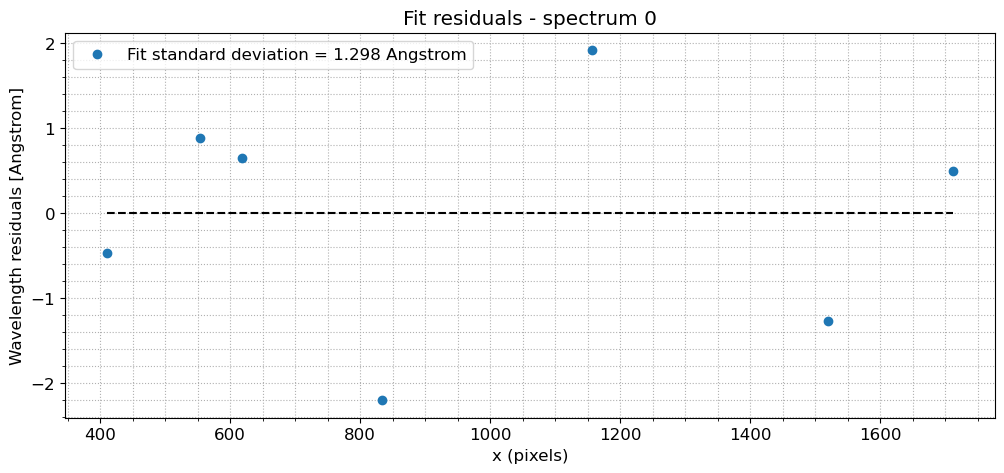

In [34]:
wavelengths_list, wavelengths_fit_std_list = extraction.wavelength_calibration(lamp_peak_positions_list, corresponding_wavelengths, poly_order=3, diagnostic_plots = True)

Remember: the wavelengths must always be in Angstrom!

Here we used a 3rd degree polynomial for the calibration and the residuals look quite good. If you want, you can plot the calibrated spectrum as you prefer:

Text(0.5, 1.0, 'Spectrum 0 calibrated in wavelength')

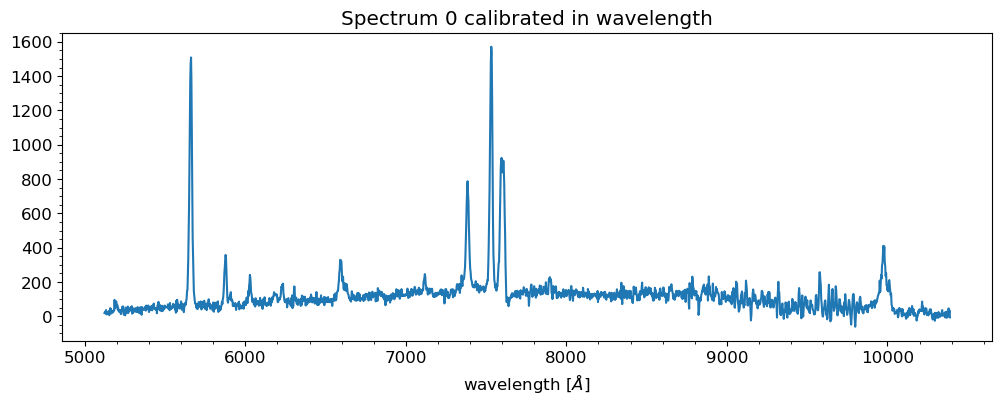

In [35]:
plt.figure(figsize=(12,4))
plt.plot(wavelengths_list[0],spec_extract_list[0])
plt.minorticks_on()
plt.xlabel("wavelength [$\AA$]")
plt.title("Spectrum 0 calibrated in wavelength")

That's it for the wavelength calibration!

## Step 5. Correcting for atmospheric extinction

The observed spectrum was absorbed/scattered by Earth's atmosphere in a wavelength dependent way and we have to correct for that.

In the `extraction.extinction_correction()` function below we set our observatory as "lapalma" (options are "ctio", "kpno", "lapalma", "mko", "mtham", "paranal", "apo") and set data_type="target" to correctly select the airmass for the extinction correction. For the std star, analyzed a few cells below, we have to set data_type="std_star". If your observatory is not listed here, you can set **custom_observatory = "Path/to/file.txt"**, where the string must be the path to a txt file containing the airmass extinction curve. This file must have two columns, the first with the wavelengths **in Angstroms** and the second with the extinction in mag/airmass.

The **spline_order** is the interpolation polynomial order for the spline.

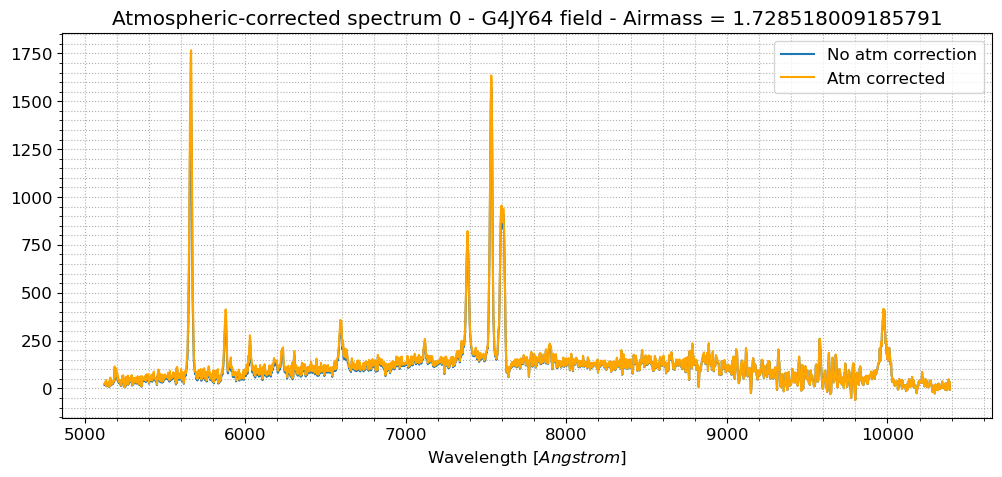

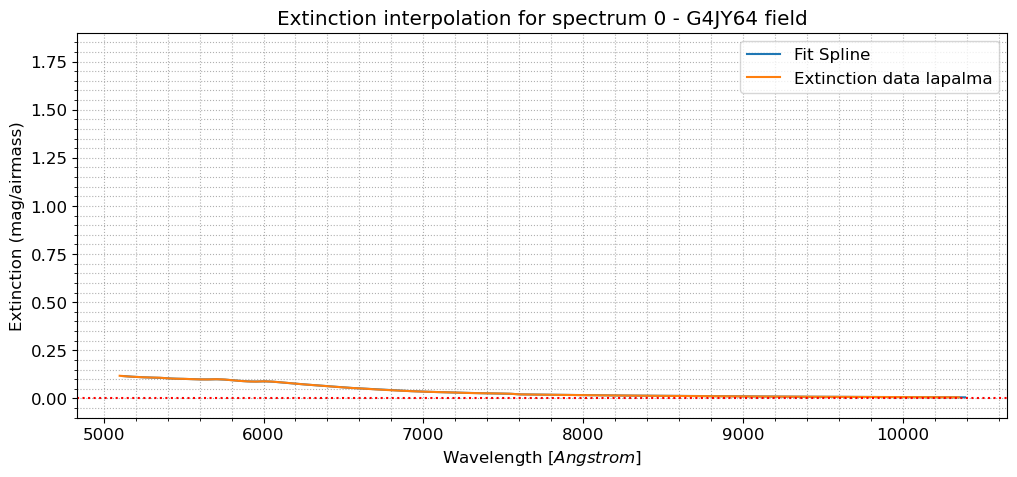

Please cite the work where this extinction curve was measured:
Extinction table for Roque de Los Muchachos Observatory, La Palma. Described in https://www.ing.iac.es/Astronomy/observing/manuals/ps/tech_notes/tn031.pdf


In [42]:
spec_atm_corrected_list = extraction.extinction_correction(spec_extract_list, wavelengths_list, observatory="lapalma", data_type="target", custom_observatory = None, spline_order = 1, plots = True)

## Step 6. Let's repeat the process for the standard star

However, let's set all the plotting variables as **False** for simplicity.

In [37]:
spine_std = extraction.tracing(std_data, method="moments", peak_height=100,poly_order=2, xlims=[150,2020], y_pixel_range=15, main_plot = False, plot_residuals=False)

In [38]:
spec_std_list, lamp_spec_list_std, lamp_peak_positions_list_std = extraction.extracting(std_data, spine_std, master_lamp_data="./master_lamp.fits", trace_half_width = 7, shift_y_pixels = 21, lamp_peak_height=10000, peak_distance=30, diagnostic_plots = False, spec_plots = False)

In [39]:
lamp_peak_positions_list_std = [np.asarray([412, 553, 619, 833, 1156, 1520, 1711])]
corresponding_wavelengths = [6143.0626,6506.5281, 6678.2762, 7245.1666,8112.9012,9122.967,9657.7060]

In [40]:
wavelengths_std, _ = extraction.wavelength_calibration(lamp_peak_positions_list_std, corresponding_wavelengths, poly_order=3, diagnostic_plots = False)

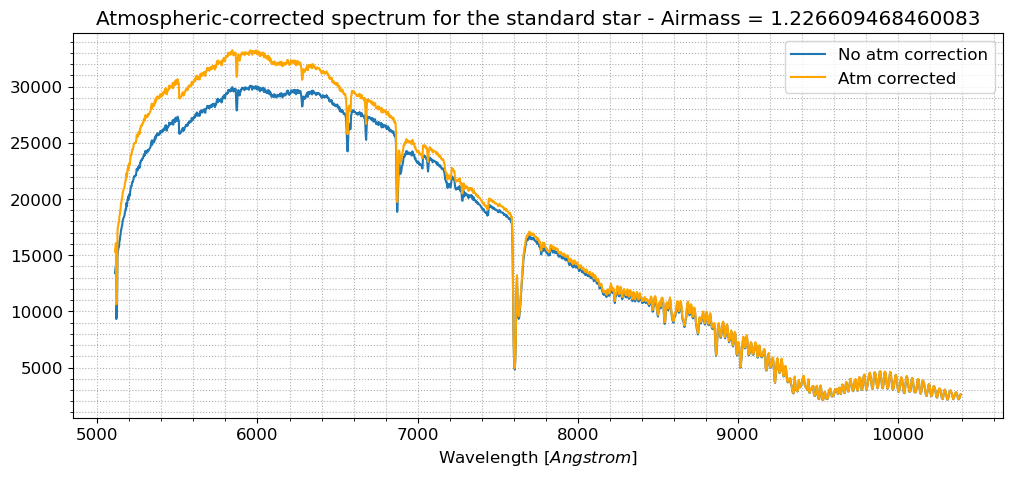

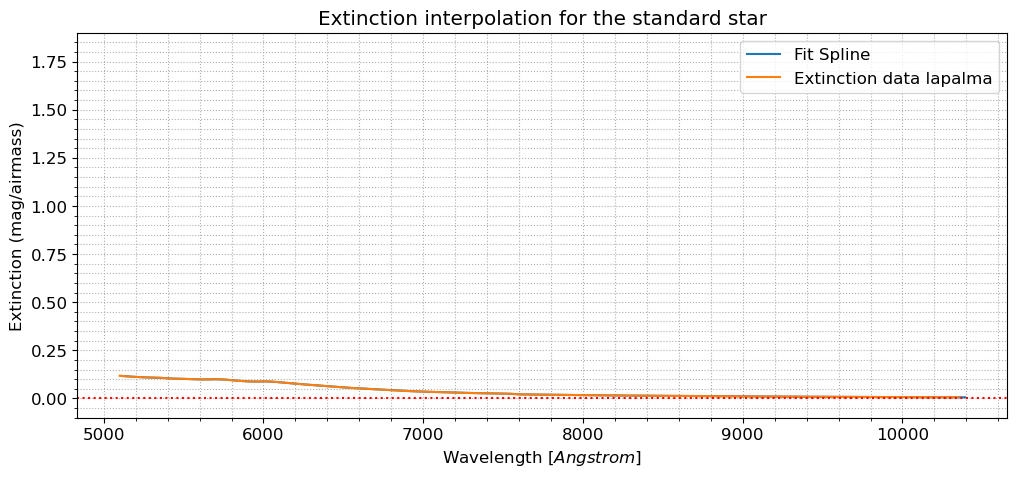

Please cite the work where this extinction curve was measured:
Extinction table for Roque de Los Muchachos Observatory, La Palma. Described in https://www.ing.iac.es/Astronomy/observing/manuals/ps/tech_notes/tn031.pdf


In [41]:
spec_atm_corrected_std = extraction.extinction_correction(spec_std_list, wavelengths_std, observatory="lapalma", data_type="std_star", custom_observatory = None, spline_order = 1, plots = True)

## Step 7. Finding the standard star archival data

You can find your standard star in our dataset. If you don't know its dataset and name, you can call the function `extraction.list_available_standards()`, as shown below:

In [44]:
extraction.list_available_standards()

Available datasets:
blackbody
bstdscal
ctiocal
ctionewcal
iidscal
irscal
oke1990
redcal
spec16cal
spec50cal
spechayescal


now yo ucan look for the standard star in one of the datasets listed above:

In [46]:
extraction.list_available_standards(std_star_dataset="irscal")

(['feige56.dat',
  'hd84937.dat',
  'hd86986.dat',
  'feige92.dat',
  'feige25.dat',
  'he3.dat',
  'bd332642.dat',
  'hd192281.dat',
  'hd17520.dat',
  'hd217086.dat',
  'feige110.dat',
  'hr7001.dat',
  'bd253941.dat',
  'hd74721.dat',
  'hd109995.dat',
  'kopff27.dat',
  'names.men',
  'bd284211.dat',
  'hiltner600.dat',
  'feige15.dat',
  'wolf1346.dat',
  'bd404032.dat',
  'feige34.dat',
  'bd262606.dat',
  'hd60778.dat',
  'bd082015.dat',
  'bd174708.dat',
  'hd161817.dat',
  'g191b2b.dat',
  'hiltner102.dat',
  'hd19445.dat',
  'standards.men',
  'feige98.dat',
  'hd117880.dat',
  'hz44.dat',
  'hd2857.dat'],
 "Dataset of the KPNO IRS standards at 78 bandpasses, data from various sources transformed to the Hayes and Lathamsystem, unpublished (note that in this dataset the brighter standards have no values - the `bstdscal' dataset must be used for these standards at this time).")

## Step 8. Flux calibration

In our case, the standard star dataset is std_star_dataset="irscal", and the data file is std_star_archive_file = "bd332642.dat". Let's use these values in the function `extraction.std_star_normalization()` below to find the flux-calibration solution for the standard star:

Dataset of the KPNO IRS standards at 78 bandpasses, data from various sources transformed to the Hayes and Lathamsystem, unpublished (note that in this dataset the brighter standards have no values - the `bstdscal' dataset must be used for these standards at this time).


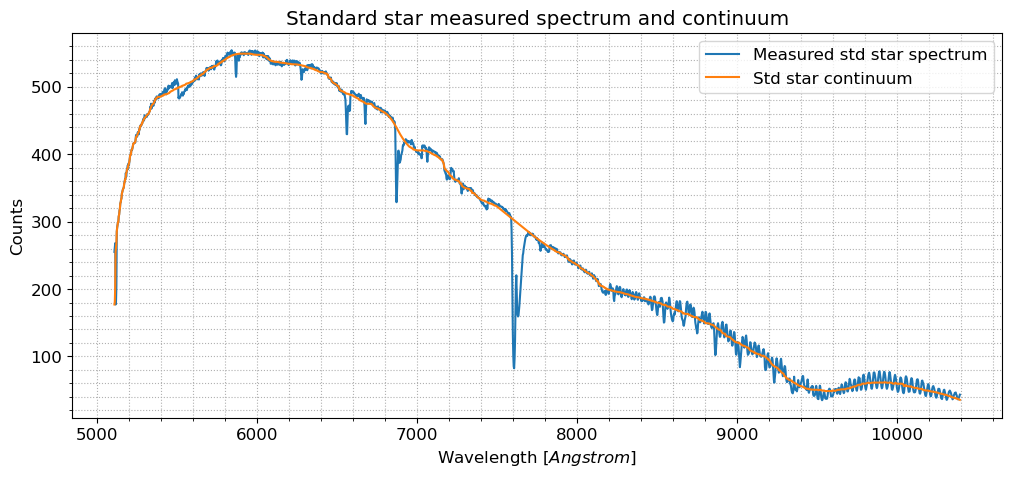

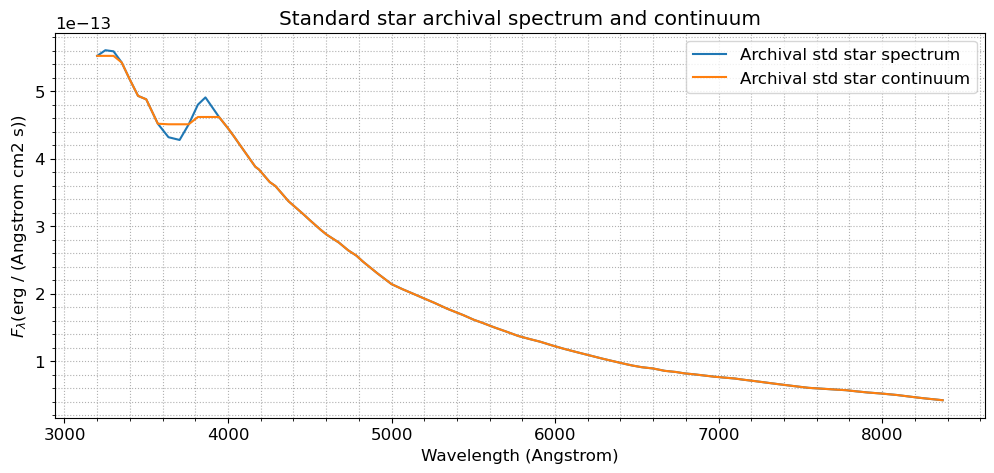

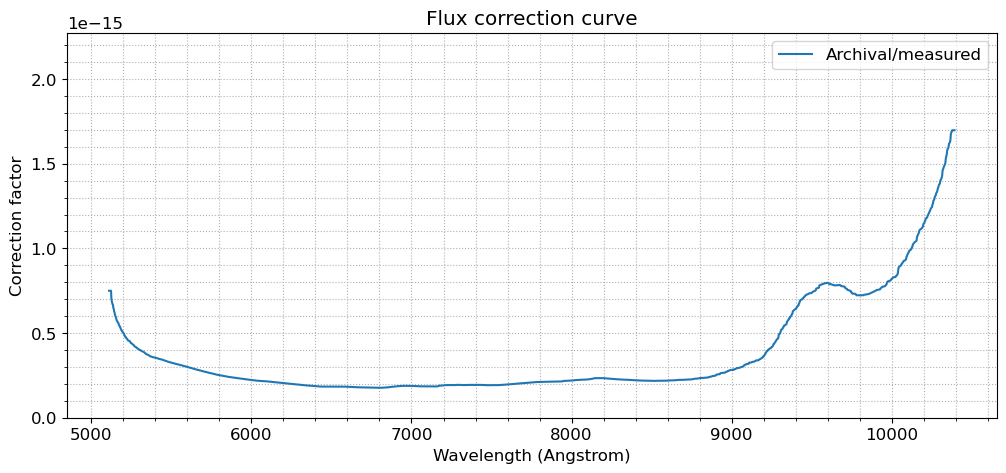

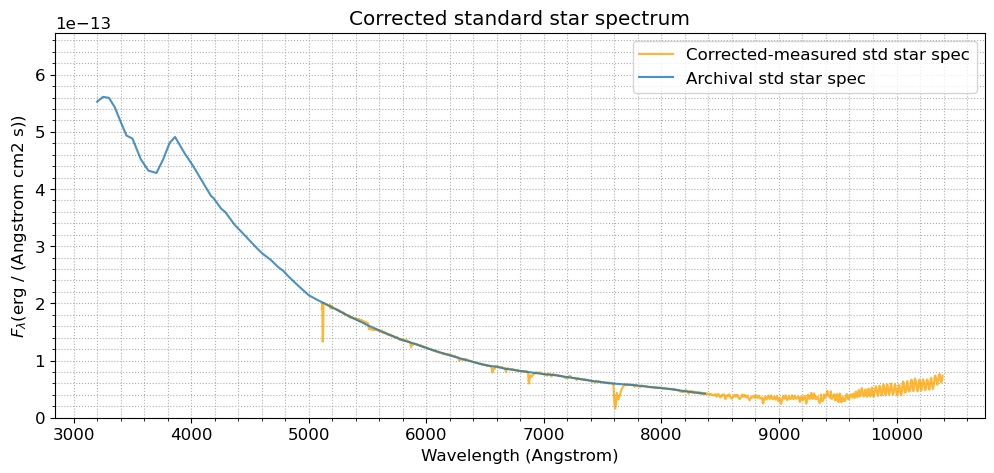

In [48]:
correction_factor = extraction.std_star_normalization(spec_atm_corrected_std, wavelengths_std, std_star_dataset="irscal", std_star_archive_file = "bd332642.dat", smooth_window = 101, exclude_regions = [[6800,6950],[7500,7850]], smooth_window_archive = 5, interpolation_order=2, plots = True)

The other important input variables here are

**smooth_window** = 101: This must be an odd number. This is the number of neighbouring wavelength bins used to extract the standard star continuum with a median filter.

**exclude_regions** = [[6800,6950],[7500,7850]]: This is a list of regions ( sublists in Angstroms) to be excluded from the measured standard star spectrum when extracting its continuum. For instance, you may want to exclude the regions with telluric absorption lines.

smooth_window_archive = 5: The same as **smooth_window**, but for the archival spectrum.

From the first two plots above, we see how the measured spectrum is different from the corrected spectrum. The third plot shows the computed correction factor and the final plot shows the calibrated standard star spectrum.

Now let's finaly calibrate the density flux in our spectrum:

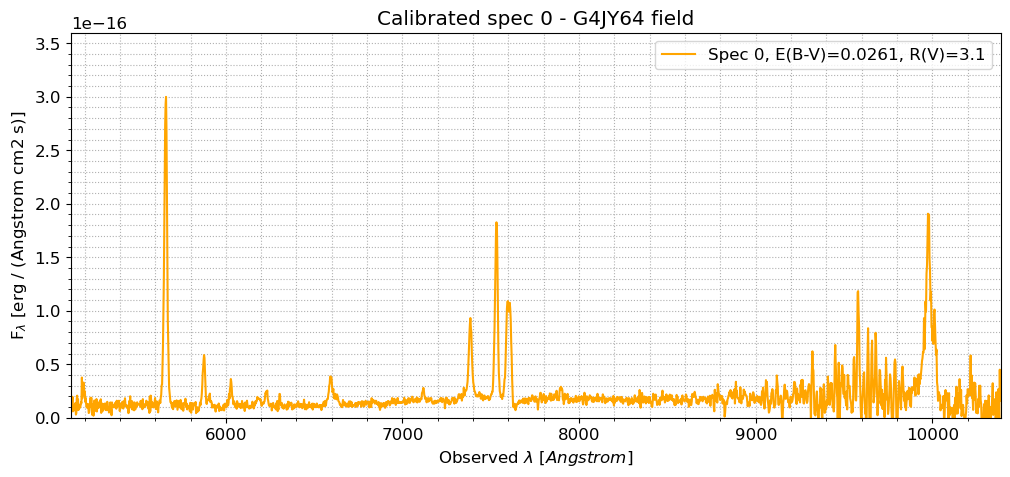

In [49]:
calibrated_flux = extraction.target_flux_calibration(wavelengths_list, spec_atm_corrected_list, correction_factor, reddening = reddening, Rv = None,
                                                     wavelength_cuts = [4500,11500], output_directory = output_directory, save_spec = True, plot = True)

If Rv = None, it will be automatically set as Rv = 3.1.

The input variable **wavelength_cuts** helps you to cutoff the edges of the spectrum, which may be too noisy.

If **save_spec = True**, this final result will be saved into a ".dat" file in the directory **output_directory**.


That's it for spectral extraction!